## Imports

In [67]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Mathematical Functions

In [68]:
class MathematicalFunctions:
    def function_1(self, x):
        # y = sin(x) * cos(x) * x
        return np.sin(x) * np.cos(x) * x

    def function_2(self, x):
        # y = e^x * sin(x)
        return np.exp(x) * np.sin(x)

    def function_3(self, x):
        # y = x^2 * tan(x)
        return x**2 * np.tan(x)

    def function_4(self, x):
        # y = x * e^(-x) * cos(x)
        return x * np.exp(-x) * np.cos(x)

    def function_5(self, x):
        # y = x^3 * arctan(x)
        return x**3 * np.arctan(x)

    def function_6(self, x):
        # y = e^(x^2) * sin(x) * cos(x)
        return np.exp(x**2) * np.sin(x) * np.cos(x)

    def function_7(self, x):
        # y = ln(1 + x^2) * sin^2(x)
        return np.log(1 + x**2) * np.sin(x) ** 2

    def function_8(self, x):
        # y = sin(x) * cosh(x)
        return np.sin(x) * np.cosh(x)

    def function_9(self, x):
        # y = e^x * sin(x^2)
        return np.exp(x) * np.sin(x**2)

    def function_10(self, x):
        # y = x^4 - 2x^2 + cos(x)
        return x**4 - 2 * x**2 + np.cos(x)

    def get_function(self, func_number, x):
        """

        Parameters:
        func_number (int): The number of the function to plot (1-10).
        x_range (tuple): A tuple of the form (start, end) specifying the range of x values.
        """
        function_mapping = {
            1: self.function_1,
            2: self.function_2,
            3: self.function_3,
            4: self.function_4,
            5: self.function_5,
            6: self.function_6,
            7: self.function_7,
            8: self.function_8,
            9: self.function_9,
            10: self.function_10,
        }

        y = function_mapping[func_number](x)

        # Normalize y to be between -5 and 5
        y_min, y_max = y.min(), y.max()
        y_norm = ((y - y_min) / (y_max - y_min)) * 10 - 5  # scale and shift to [-5, 5]

        # Alternatively, clip the values
        # y_norm = np.clip(y, -5, 5)
        return y_norm

    def plot_function(self,func_number,x,y):
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, label=f"Function {func_number}")
        plt.title(f"Plot of Function {func_number}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

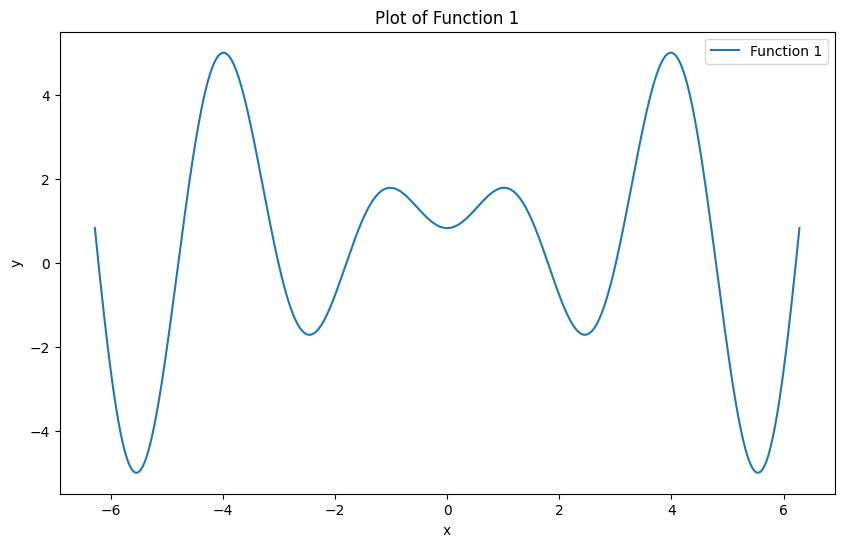

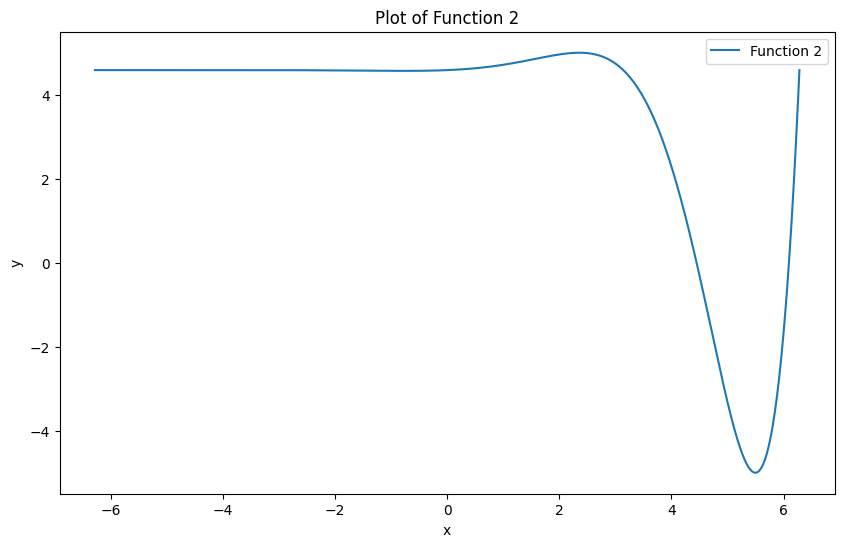

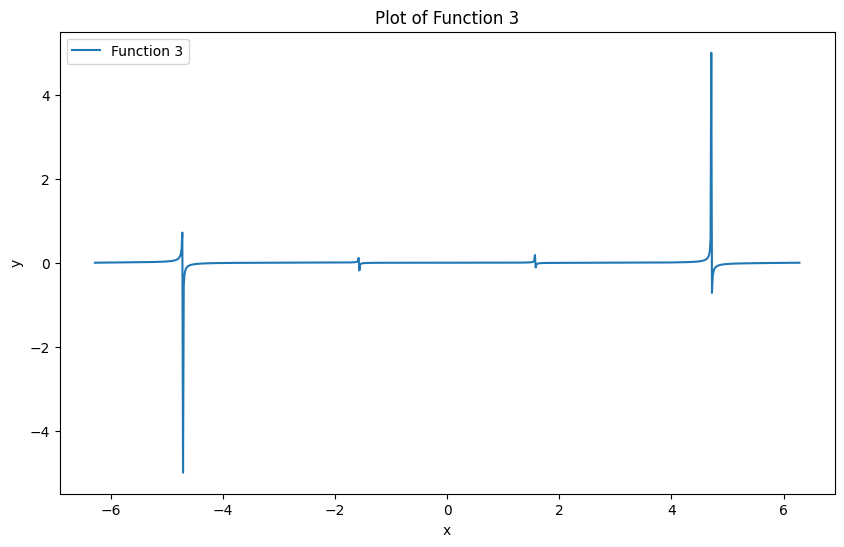

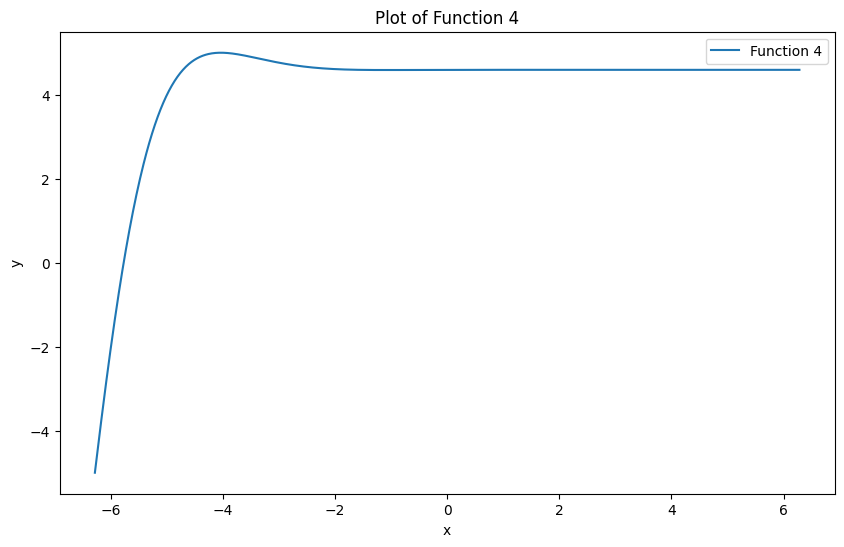

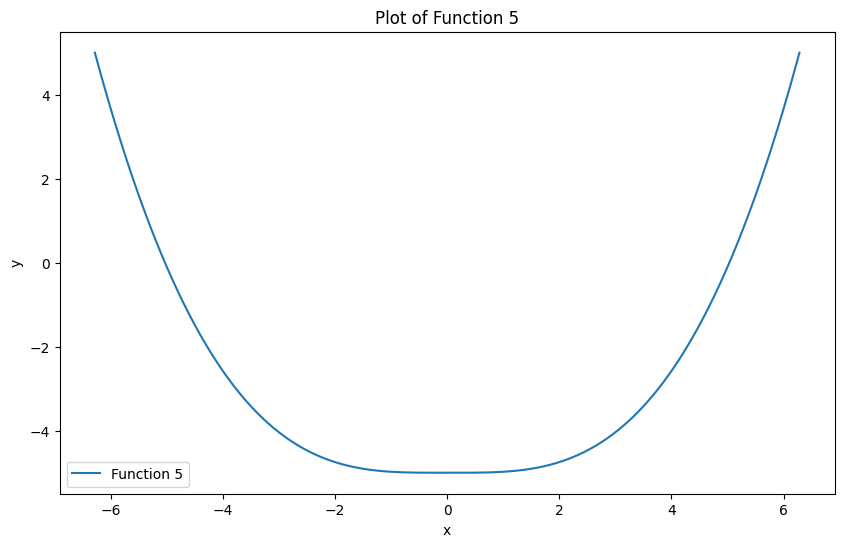

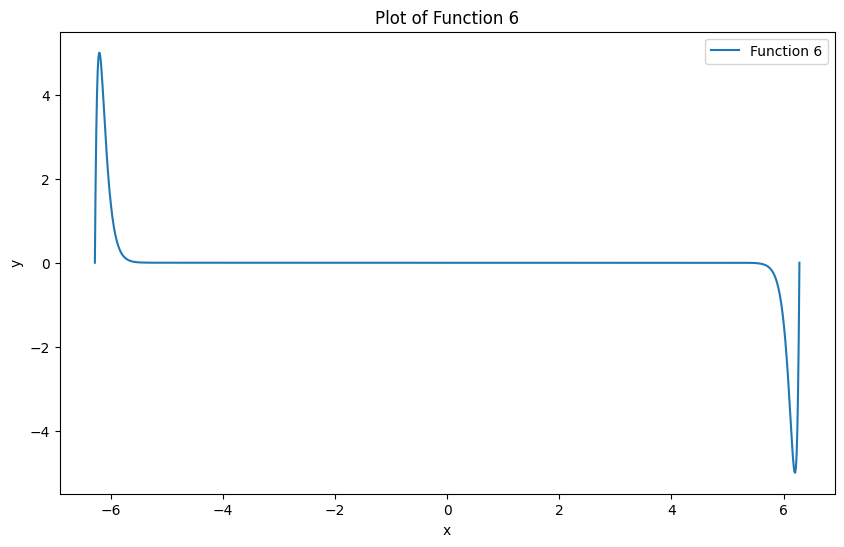

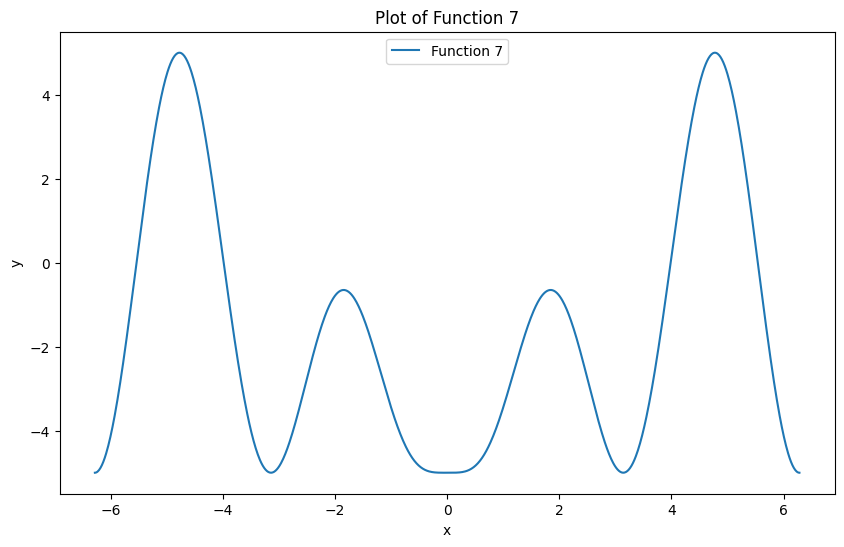

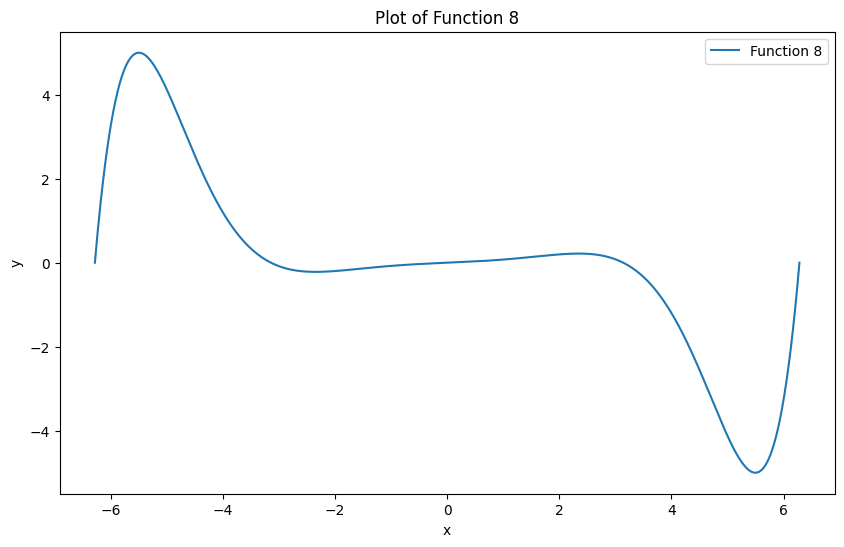

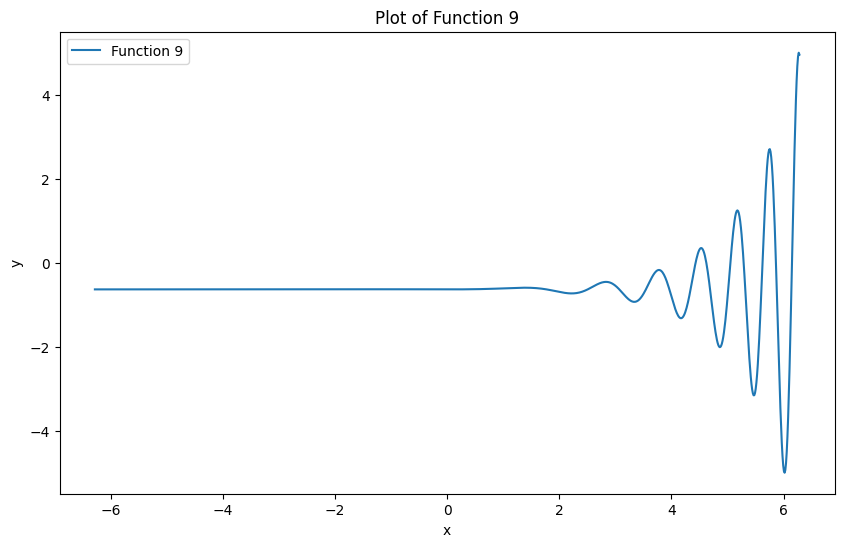

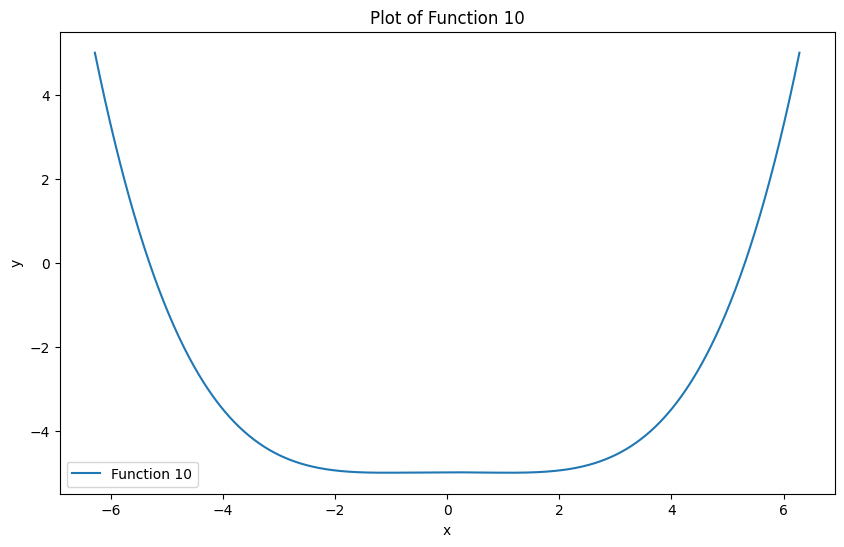

In [69]:
M = MathematicalFunctions()
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
for i in range(1, 11):
    y = M.get_function(i, x)
    M.plot_function(i,x,y)

## Neural Network definition

### Activation Function Mapping

In [70]:
ACTIVATION_FUNCTIONS = {
    "ReLU": nn.ReLU(),
    "Leaky ReLU": nn.LeakyReLU(),
    "Parameterised ReLU": nn.PReLU(),
    "Exponential ReLU": nn.ELU(),
    "Tanh": nn.Tanh(),
    "Sigmoid": nn.Sigmoid(),
    "Swish": lambda x: x * torch.sigmoid(x),  # Swish activation
}

### Neural Network Class

In [71]:
class ComplexNN(nn.Module):
    def __init__(
        self,
        l1_reg=0.0,
        l2_reg=0.0,
        dropout_rate=0.0,
        noise_std=0.0,
        activation="ReLU",
        batch_norm=False,
        layers=[1, 64, 128, 64, 32, 1],
    ):
        super(ComplexNN, self).__init__()

        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.noise_std = noise_std
        self.activation_func = ACTIVATION_FUNCTIONS[activation]

        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], layers[2])
        self.layer3 = nn.Linear(layers[2], layers[3])
        self.layer4 = nn.Linear(layers[3], layers[4])
        self.layer5 = nn.Linear(layers[4], layers[5])

        if batch_norm:
            self.batch_norm1 = nn.BatchNorm1d(layers[1])
            self.batch_norm2 = nn.BatchNorm1d(layers[2])
            self.batch_norm3 = nn.BatchNorm1d(layers[3])
            self.batch_norm4 = nn.BatchNorm1d(layers[4])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, batch_norm=False, dropout=False):
        if self.noise_std > 0:
            x += torch.normal(0, self.noise_std, size=x.shape)

        if batch_norm:
            x = self.activation_func(self.batch_norm1(self.layer1(x)))
            x = self.activation_func(self.batch_norm2(self.layer2(x)))
            if dropout:
                x = self.dropout(x)
            x = self.activation_func(self.batch_norm3(self.layer3(x)))
            x = self.activation_func(self.batch_norm4(self.layer4(x)))
            x = self.layer5(x)
        else:
            x = self.activation_func(self.layer1(x))
            x = self.activation_func(self.layer2(x))
            if dropout:
                x = self.dropout(x)
            x = self.activation_func(self.layer3(x))
            x = self.activation_func(self.layer4(x))
            x = self.layer5(x)
        return x

    def regularisation_loss(self):
        l1_loss = sum(p.abs().sum() for p in self.parameters())
        l2_loss = sum(p.pow(2).sum() for p in self.parameters())
        return self.l1_reg * l1_loss + self.l2_reg * l2_loss

### Initialize weights

In [72]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight, -1, 1)
        m.bias.data.fill_(0.01)

### Training function with recording predictions and weights

In [73]:
def train_model_and_store_predictions(
    model,
    x_train,
    y_train,
    x_val,
    y_val,
    epochs=100,
    lr=0.01,
    use_early_stopping=True,
    patience=10,
):
    # Initialize weights
    model.apply(init_weights)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    predictions_list = []
    loss_values = []

    best_loss = float("inf")
    epochs_without_improvement = 0
    best_model_state = None

    weights_list = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train) + model.regularisation_loss()
        loss.backward()
        optimizer.step()

        predictions_list.append(outputs.detach().numpy())
        loss_values.append(loss.item())

        # Early stopping logic
        if use_early_stopping:
            with torch.no_grad():
                val_outputs = model(x_val)
                val_loss = criterion(val_outputs, y_val)
                if val_loss < best_loss:
                    best_loss = val_loss
                    epochs_without_improvement = 0
                    best_model_state = model.state_dict().copy()
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement == patience:
                        model.load_state_dict(best_model_state)
                        break

        weights_list.append([p.data.clone() for p in model.parameters()])

    return predictions_list, loss_values, weights_list

## Main Functions

In [74]:
def compute_metrics(model, data_loader):
    criterion = torch.nn.MSELoss()
    model.eval()  # Set the model to evaluation mode
    total_loss, total_mae, total_samples, sum_squared_error, sum_variance = (
        0.0,
        0.0,
        0,
        0.0,
        0.0,
    )
    total_actual_sum, total_actual_squared_sum = 0.0, 0.0

    with torch.no_grad():  # No need to track gradients
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            total_mae += np.sum(np.abs(outputs.numpy() - targets.numpy()))
            total_samples += inputs.size(0)

            # For R-squared and Explained Variance
            sum_squared_error += np.sum((outputs.numpy() - targets.numpy()) ** 2)
            total_actual_sum += np.sum(targets.numpy())
            total_actual_squared_sum += np.sum(targets.numpy() ** 2)

    mse = total_loss / total_samples
    mae = total_mae / total_samples
    rmse = np.sqrt(mse)

    # Calculate R-squared and Explained Variance
    mean_actual = total_actual_sum / total_samples
    total_variance = total_actual_squared_sum - (mean_actual**2) * total_samples
    r_squared = 1 - (sum_squared_error / total_variance)
    explained_variance = 1 - (
        sum_squared_error / (total_variance + 1e-10)
    )  # Adding a small constant to avoid division by zero

    return mae, mse, rmse, r_squared, explained_variance

In [75]:
def main(
    _num_epochs=100,
    _batch_norm=False,
    _batch_size=10,
    _l1=0.0001,
    _l2=0.0001,
    _dropout_rate=0.01,
    _noise_std=0.1,
    _activation="ReLU",
    _early_stopping=False,
    _patience=1,
    _selected_model="No Regularisation",
    _layers=[1, 10, 8, 8, 10, 1],
    _visuals_on=False,
):
    # Batch Normalization Option
    if _batch_norm:
        # Create a DataLoader with the specified batch size
        dataset = TensorDataset(x_train_tensor, y_train_tensor)
        train_loader = DataLoader(dataset, batch_size=_batch_size, shuffle=True)
    else:
        train_loader = [(x_train_tensor, y_train_tensor)]

    # Mapping of model names to their instances
    model_mapping = {
        # Mapping of model names to their instances
        "No Regularisation": ComplexNN(layers=_layers),
        "L1 Regularisation": ComplexNN(l1_reg=_l1, layers=_layers),
        "L2 Regularisation": ComplexNN(l2_reg=_l2, layers=_layers),
        "L1 & L2 Regularisation": ComplexNN(l1_reg=_l1, l2_reg=_l2, layers=_layers),
        "Dropout": ComplexNN(dropout_rate=_dropout_rate, layers=_layers),
        "Noise Injection": ComplexNN(noise_std=_noise_std, layers=_layers),
        "Batch Normalisation": ComplexNN(batch_norm=_batch_norm, layers=_layers),
        "Custom Model": ComplexNN(
            l1_reg=_l1,
            l2_reg=_l2,
            dropout_rate=_dropout_rate,
            noise_std=_noise_std,
            activation=_activation,
            batch_norm=_batch_norm,
            layers=_layers,
        ),
    }

    model_instance = model_mapping[_selected_model]

    # print((f"Training {_selected_model}..."))

    predictions_list, loss_values, weights_list = train_model_and_store_predictions(
        model_instance,
        x_train_tensor,
        y_train_tensor,
        x_val_tensor,
        y_val_tensor,
        epochs=_num_epochs,
        use_early_stopping=_early_stopping,
        patience=_patience,
    )

    model_instance.eval()  # Set the model to evaluation mode
    mae, mse, rmse, r_squared, explained_variance = compute_metrics(
        model_instance, train_loader
    )

    # print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nR2: {r_squared}\nExp Var: {explained_variance}")

    if _visuals_on:
        if predictions_list:
            # Assuming predictions_list[-1] contains the final epoch predictions
            final_epoch_predictions = predictions_list[-1]

            plt.figure(figsize=(10, 6))
            plt.scatter(
                x_train_tensor,
                y_train_tensor,
                color="blue",
                alpha=0.5,
                label="Actual Data",
            )
            plt.scatter(
                x_train_tensor,
                final_epoch_predictions,
                color="red",
                alpha=0.5,
                label="Model Predictions",
            )
            plt.title("Model Predictions vs Actual Data (Final Epoch)")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.legend()
            plt.show()
        else:
            print("No predictions available to plot.")

    return mae, mse, rmse, r_squared, explained_variance

In [76]:
def get_params(
    _num_epochs=500,
    _batch_norm=False,
    _batch_size=1,  # 10
    _l1=0,  # 0.0001
    _l2=0,
    _dropout_rate=0,  # 0.01
    _noise_std=0,  # 0.1
    _activation="ReLU",
    _early_stopping=False,
    _patience=0,  # 1
    _selected_model="No Regularisation",
    _layers=[1, 8, 10, 10, 8, 1],
):
    return (
        _num_epochs,
        _batch_norm,
        _batch_size,
        _l1,
        _l2,
        _dropout_rate,
        _noise_std,
        _activation,
        _early_stopping,
        _patience,
        _selected_model,
        _layers,
    )

## Experiment

In [77]:
def run_trial(params):
    return main(
        _num_epochs=params[0],
        _batch_norm=params[1],
        _batch_size=params[2],
        _l1=params[3],
        _l2=params[4],
        _dropout_rate=params[5],
        _noise_std=params[6],
        _activation=params[7],
        _early_stopping=params[8],
        _patience=params[9],
        _selected_model=params[10],
        _layers=params[11],
    )

In [78]:
def run_experiment(params, n_trials=10):
    averages = [0, 0, 0, 0, 0]

    for i in range(n_trials):
        mae, mse, rmse, r_squared, explained_variance = run_trial(params)
        averages[0] += mae
        averages[1] += mse
        averages[2] += rmse
        averages[3] += r_squared
        averages[4] += explained_variance

    for i in range(len(averages)):
        averages[i] /= n_trials

    print("Metrics:")
    s = ""
    for val in averages:
        s += str(round(val, 4)) + ", "
    print(s)
    return averages

In [79]:
# ComplexNN init: l1_reg=0.0, l2_reg=0.0, dropout_rate=0.0, noise_std=0.0, activation="ReLU", batch_norm=False, layers= [1,64,128,64,32,1]

model_options = [
    "No Regularisation",
    "L1 Regularisation",
    "L2 Regularisation",
    "L1 & L2 Regularisation",
    "Dropout",
    "Noise Injection",
    "Batch Normalisation",
    "Custom Model",
]

In [80]:
def get_no_reg():
    print("Training No Regularisation...")
    return get_params()


def get_l1_reg():
    print("Training L1 Regularisation...")
    return get_params(_l1=0.0001, _selected_model="L1 Regularisation")


def get_l2_reg():
    print("Training L2 Regularisation...")
    return get_params(_l2=0.0001, _selected_model="L2 Regularisation")


def get_elasticnet_reg():
    print("Training Elastic Net Regularisation...")
    return get_params(_l1=0.0001, _l2=0.0001, _selected_model="L1 & L2 Regularisation")


def get_dropout_reg():
    print("Training Dropout...")
    return get_params(_dropout_rate=0.01, _selected_model="Dropout")


def get_noise_reg():
    print("Training Noise Injection...")
    return get_params(_noise_std=0.01, _selected_model="Noise Injection")


def get_batch_reg():
    print("Training Batch Normalisation...")
    return get_params(
        _batch_norm=True, _batch_size=32, _selected_model="Batch Normalisation"
    )

## Run Experiment

### Dataset

In [81]:
def get_dataset(x, y_true):
    y_noisy = y_true + np.random.normal(0, 0.1, y_true.shape)

    # Convert to tensor
    x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
    y_tensor = torch.tensor(y_noisy, dtype=torch.float32).view(-1, 1)

    # Split data into training, validation, and test sets
    x_train_tensor, x_temp_tensor, y_train_tensor, y_temp_tensor = train_test_split(
        x_tensor, y_tensor, test_size=0.2, random_state=42
    )
    x_val_tensor, x_test_tensor, y_val_tensor, y_test_tensor = train_test_split(
        x_temp_tensor, y_temp_tensor, test_size=0.5, random_state=42
    )
    
    return x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, x_test_tensor, y_test_tensor

In [82]:
math_funcs = MathematicalFunctions()

def true_function(func_number, x):
    return math_funcs.get_function(func_number, x)

### Running Experiment

In [83]:
all_params = [
    get_no_reg(),
    get_l1_reg(),
    get_l2_reg(),
    get_elasticnet_reg(),
    get_dropout_reg(),
    get_noise_reg(),
    get_batch_reg(),
]

all_values = []
def run_function_experiment():
    function_all_values = []
    for params in all_params:
        metrics = run_experiment(params)
        function_all_values.append(metrics)
        print(
            "------------------------------------------------------------------------------"
        )
    return function_all_values


Training No Regularisation...
Training L1 Regularisation...
Training L2 Regularisation...
Training Elastic Net Regularisation...
Training Dropout...
Training Noise Injection...
Training Batch Normalisation...


## Run All Experiments

In [84]:
math_funcs = MathematicalFunctions()
values = []

for i in range(1, 11):
    # Get data
    x = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
    y_true = true_function(i, x)
    x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, x_test_tensor, y_test_tensor = get_dataset(x, y_true)
    #run experiment
    print("Experiment", i)
    metrics = run_function_experiment()
    values.append(metrics)

Experiment 1


Metrics:
0.5494, 1.1621, 0.9004, 0.8329, 0.8329, 
------------------------------------------------------------------------------
Metrics:
0.1739, 0.0953, 0.2831, 0.9863, 0.9863, 
------------------------------------------------------------------------------
Metrics:
0.3545, 0.4648, 0.6246, 0.9332, 0.9332, 
------------------------------------------------------------------------------
Metrics:
0.3262, 0.4977, 0.6242, 0.9284, 0.9284, 
------------------------------------------------------------------------------
Metrics:
0.4296, 0.6813, 0.6986, 0.902, 0.902, 
------------------------------------------------------------------------------
Metrics:
1.4344, 3.6946, 1.8941, 0.4687, 0.4687, 
------------------------------------------------------------------------------
Metrics:
1.7015, 4.9304, 2.2204, 0.291, 0.291, 
------------------------------------------------------------------------------
Experiment 2
Metrics:
0.1584, 0.1587, 0.3586, 0.9785, 0.9785, 
--------------------------------------

In [85]:
print(values)

[[[0.5494407253265381, 1.1621357031166553, 0.9004231326586934, 0.8328745750212418, 0.8328745750212448], [0.17392408943176269, 0.0953372297808528, 0.2830659409918648, 0.9862896598691393, 0.9862896598691396], [0.35451434898376466, 0.46476487945765255, 0.6245639833165406, 0.9331626812291443, 0.9331626812291454], [0.3261908473968506, 0.4977329526096582, 0.6241538075382751, 0.9284215845741798, 0.9284215845741812], [0.42963287734985356, 0.681281977891922, 0.6986195404360326, 0.9020256019228101, 0.9020256019228119], [1.4344326324462888, 3.6946494936943055, 1.8941127394760358, 0.4686765889822361, 0.4686765889822457], [1.7014513807296754, 4.930401185035706, 2.220381179473066, 0.290964556855459, 0.29096455685547185]], [[0.1584362840652466, 0.15867261588573456, 0.35861597079664714, 0.9785459704616738, 0.9785459704616744], [0.14424668884277342, 0.13262997530400752, 0.29117753955641046, 0.9820671803670074, 0.9820671803670077], [0.11532413482666015, 0.05217298734933138, 0.21709317585357835, 0.992945